In [1]:
import os
import pathlib

train_datapath = pathlib.Path("/Data2/murmur/train")

os.listdir(train_datapath)[:5]

['50687_TV.wav', '84881_AV.tsv', '85317_AV.tsv', '84747_TV.wav', '78280.txt']

In [2]:
import pandas as pd 

sample_tsv = pd.read_csv(train_datapath / "9979_AV.tsv", sep="\t", header= None)
sample_tsv.columns = ["start", "end", "state"]
sample_tsv["state_duration"] = sample_tsv["end"] - sample_tsv["start"]
# sample_tsv["state"] = sample_tsv["state"].apply(lambda x: int_to_str(x))

sample_tsv.head()

,start,end,state,state_duration
0,0.000000,6.551000,0,6.551000
1,6.551000,6.712571,1,0.161571
2,6.712571,6.863459,2,0.150888
3,6.863459,7.000297,3,0.136838
4,7.000297,7.219982,4,0.219685


In [3]:
sample_tsv.tail()

,start,end,state,state_duration
26,10.639671,10.815929,2,0.176258
27,10.815929,10.940297,3,0.124368
28,10.940297,11.224529,4,0.284232
29,11.224529,11.379424,1,0.154895
30,11.379424,18.160000,0,6.780576


In [4]:
noise_front, noise_back = [], []

for filename in os.listdir(train_datapath):
    if filename.endswith(".tsv"):
        sample_tsv = pd.read_csv(train_datapath / f"{filename}", sep="\t", header= None)
        sample_tsv.columns = ["start", "end", "state"]
        sample_tsv["state_duration"] = sample_tsv["end"] - sample_tsv["start"]
        
        # Front part is noise
        if sample_tsv["state"].iloc[0] == 0: # "Noise"
            noise_front.append(sample_tsv["state_duration"].iloc[0])
        else:
            noise_front.append(0)
        if sample_tsv["state"].iloc[-1] == 0: # "Noise"
            noise_back.append(sample_tsv["state_duration"].iloc[-1])
        else:
            noise_back.append(0)

In [5]:
len(noise_front), len(noise_back)

(2532, 2532)

#### Noise Front

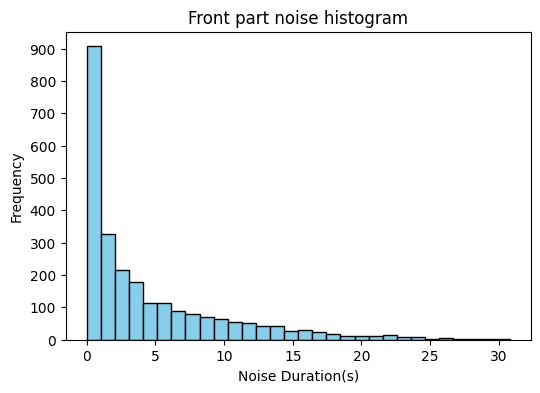

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
plt.hist(noise_front, bins=30, color='skyblue', edgecolor='black')

# y축 눈금 설정 (100 단위)
plt.yticks(range(0, 1000, 100))

# 제목 및 레이블 추가
plt.title('Front part noise histogram')
plt.xlabel('Noise Duration(s)')
plt.ylabel('Frequency')

# 그래프 표시
plt.show()

#### Noise Back

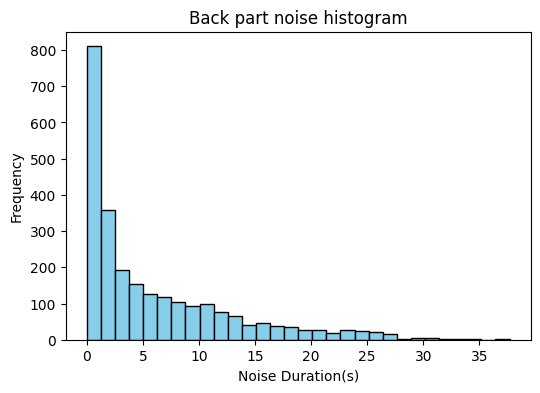

In [7]:
plt.figure(figsize=(6, 4))
plt.hist(noise_back, bins=30, color='skyblue', edgecolor='black')

# y축 눈금 설정 (100 단위)
plt.yticks(range(0, 900, 100))  # y축 범위와 간격 설정

# 제목 및 레이블 추가
plt.title('Back part noise histogram')
plt.xlabel('Noise Duration(s)')
plt.ylabel('Frequency')

# 그래프 표시
plt.show()

- In PCG signals you can check noise duration in front and back of total duration, from 0 to over 30 seconds. 

- We erased this noise duration when fits model.

In [8]:
cd /Data1/hmd2/notebooks_th/AttnLSTM_exp2

/Data1/hmd2/notebooks_th/AttnLSTM_exp2


In [10]:
from exp_settings import get_config
from dataset import load_dataframes

In [12]:
config = get_config()
df_dict = load_dataframes(config)


Train with 751 patients, 2531 recording files.


In [13]:
patient_df = df_dict["patient_df"]
recording_df = df_dict["recording_df"]

In [14]:
patient_df.head()

,murmur_label,outcome_label,systolic_timing,age,pregnant,height,weight,sex,murmur_locations,recordings,val_fold
2530,Absent,Abnormal,nan,Child,False,98.0,15.9,Female,{},"[2530_AV.wav, 2530_PV.wav, 2530_TV.wav, 2530_M...",2
9979,Present,Abnormal,Holosystolic,Child,False,103.0,13.1,Female,"{PV, MV, TV, AV}","[9979_AV.wav, 9979_PV.wav, 9979_TV.wav, 9979_M...",3
9983,Unknown,Abnormal,nan,Child,False,115.0,19.1,Male,{},"[9983_AV.wav, 9983_PV.wav, 9983_TV.wav, 9983_M...",3
13918,Present,Abnormal,Holosystolic,Child,False,98.0,15.9,Male,{TV},"[13918_AV.wav, 13918_PV.wav, 13918_TV.wav, 139...",3
14241,Present,Abnormal,Early-systolic,Child,False,87.0,11.2,Male,"{PV, MV, TV, AV}","[14241_AV.wav, 14241_PV.wav, 14241_TV.wav, 142...",1


In [16]:
recording_df.head()

,murmur_timing,rec_murmur_label,patient_murmur_label,outcome_label,val_fold
recording,,,,,
2530_AV,nan,Absent,Absent,Abnormal,2
2530_PV,nan,Absent,Absent,Abnormal,2
2530_TV,nan,Absent,Absent,Abnormal,2
2530_MV,nan,Absent,Absent,Abnormal,2
9979_AV,Holosystolic,Present,Present,Abnormal,3


- Each patient have 1 to 4 PCG recording files(ex) MV.wav, AV.wav, PV, TV, ...). 

- Thus, recording murmur label(rec_murmur_label) does not always match with patient_murmur_label.

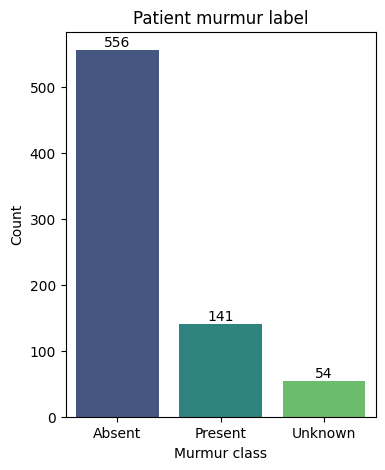

In [19]:
plt.figure(figsize=(4, 5))
sns.countplot(data=patient_df, x='murmur_label', hue= 'murmur_label',  palette='viridis', legend= False)

# 막대 그래프 위에 빈도수 표시
for bar in plt.gca().patches:
    plt.gca().text(
        bar.get_x() + bar.get_width() / 2,  # 막대의 중앙 위치
        bar.get_height() + 5.0,            # 막대 높이 위에 위치
        int(bar.get_height()),             # 빈도수
        ha='center', fontsize=10, color='black'
    )

plt.title('Patient murmur label', fontsize=12)
plt.xlabel('Murmur class', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.show()


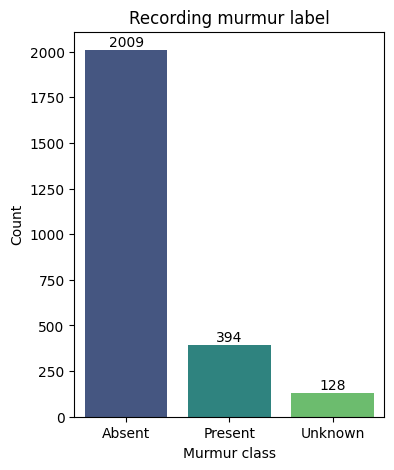

In [20]:
plt.figure(figsize=(4, 5))
sns.countplot(data=recording_df, x='rec_murmur_label', hue= 'rec_murmur_label',  palette='viridis')

# 막대 그래프 위에 빈도수 표시
for bar in plt.gca().patches:
    plt.gca().text(
        bar.get_x() + bar.get_width() / 2,  # 막대의 중앙 위치
        bar.get_height() + 20.0,            # 막대 높이 위에 위치
        int(bar.get_height()),             # 빈도수
        ha='center', fontsize=10, color='black'
    )

plt.title('Recording murmur label', fontsize=12)
plt.xlabel('Murmur class', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.show()


- Because of clinical data's property, we can check it is imbalanced data.

In [21]:
cd /Data2/murmur/train

/Data2/murmur/train


In [21]:
import os 
import pandas as pd 

def extract_audio_len(path):
    sample_tsv = pd.read_csv(f'{path}', sep="\t", header= None)
    sample_tsv.columns = ['start', 'end', 'state']
    return sample_tsv['end'].iloc[-1].item() # Extract audio ends timestamp.

tsv_list = [i for i in os.listdir(train_datapath) if i.endswith(".tsv")] # Load tsv file list.
audio_len_list = [extract_audio_len(train_datapath / tsv_path) for tsv_path in tsv_list] # Apply extract_audio_len func to all tsv files.

In [22]:
# Maybe 50782_MV_1.tsv is mis-recording file, cause its length is zero.
min([i for i in audio_len_list if i > 0]), max(audio_len_list)

(2.141799, 61.84)

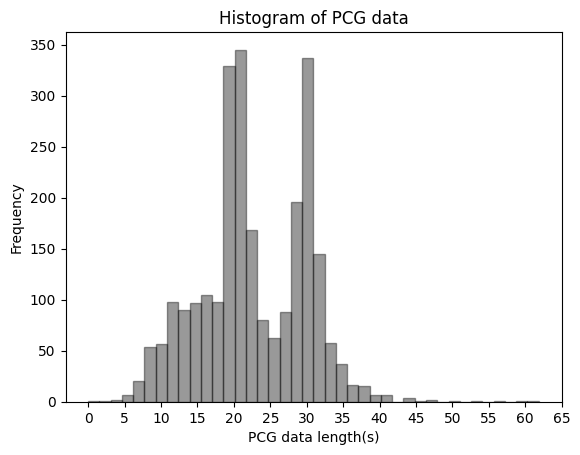

In [29]:
# 히스토그램 그리기
plt.hist(audio_len_list, bins= 40, color='black', edgecolor='black', alpha=0.4)

# 그래프 제목과 축 레이블 설정
plt.title('Histogram of PCG data')
plt.xlabel('PCG data length(s)')
plt.ylabel('Frequency')
plt.xticks(range(0, 62 + 5, 5))

# 그래프 표시
plt.show()

In [28]:
# import os
# import pandas as pd 
# import matplotlib.pyplot as plt
# from matplotlib.lines import Line2D
# from matplotlib.patches import Patch
# import seaborn as sns 
# import librosa
# import librosa.display

In [34]:
import numpy as np
import torch 

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from scipy.io.wavfile import read
from scipy.signal import stft
import librosa

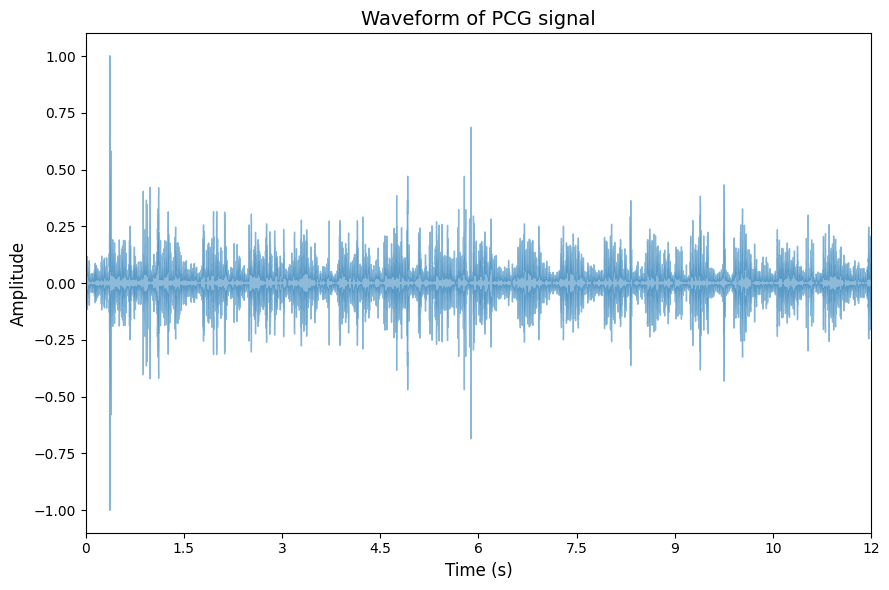

In [35]:
filename = "9979_AV"
y, sr = librosa.load(train_datapath / f"{filename}.wav", sr=4000)

# 그래프 크기 지정 및 Waveform plot 
plt.figure(figsize=(9, 6))
librosa.display.waveshow(y, sr=sr, alpha=0.5)

# 범례 및 축범위 지정
plt.xlim(0, 12)

# 그래프 제목 및 x, y축 이름
plt.title('Waveform of PCG signal', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.tight_layout()
plt.show()

In [38]:
sample_tsv = pd.read_csv(train_datapath / "9979_AV.tsv", sep='\t', header= None)
sample_tsv.columns = ['start', 'end', 'state']

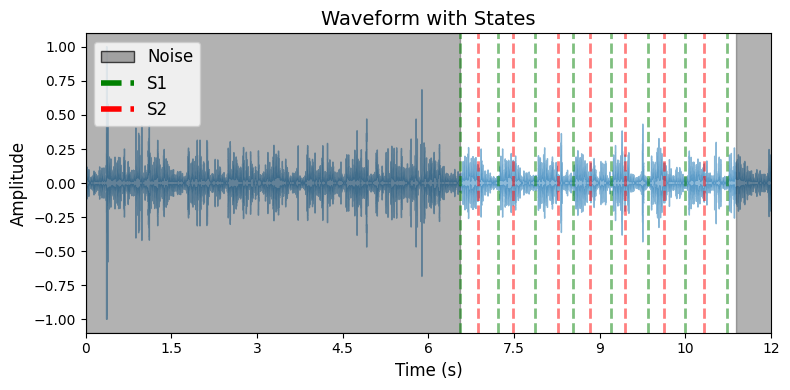

In [43]:
# state 맵핑용 딕셔너리 생성
state_dict = {0: "Noise", 1: 'S1', 2: 'Systole', 3: 'S2', 4: 'Diastole'}


# audio_path = "9979_AV.wav"  # 오디오 파일 경로
filename = "9979_AV"
y, sr = librosa.load(train_datapath / f"{filename}.wav", sr=4000)


# 그래프 크기 지정 및 Waveform plot 
plt.figure(figsize=(8, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.5)


for _, row in sample_tsv.iterrows():
    start_time = row['start'] # 시작 지점
    end_time = row['end'] # 종료 지점
    state = row['state'] # 구간 상태
    
    # If audio startswith noise part
    if (state == 0) & (start_time == 0):
        # plt.axvline(x= end_time, color= 'black', linestyle='--', alpha= 0.6)
        plt.axvspan(start_time, end_time, color='black', alpha=0.3) 
        # plt.text((start_time + end_time) / 2, 1, 'Noise', color='black', fontsize= 15, ha='left', va= 'top')
        
    # S1, S2 시작점과 종료지점 라인 추가 
    if state == 1:
        plt.axvline(x= start_time, color= 'green', linestyle='--', lw= 2.0, alpha= 0.5)
    
    if state == 3:
        plt.axvline(x= start_time, color= 'red', linestyle='--', lw= 2.0, alpha= 0.5)

    # If audio endswith noise part
    if (state == 0) & (start_time != 0):
        plt.axvspan(start_time, end_time, color='black', alpha=0.3) 
        # plt.text((start_time + end_time) / 2, 1, 'Noise', color='black', fontsize= 15, ha='left', va= 'top')


legend_elements = [
    # Line2D([0], [0], color='black', marker='s', markerfacecolor='black', markersize=10, label='Noise'),
    Patch(facecolor='gray', edgecolor='black', alpha= 0.7, label='Noise'), 
    Line2D([0], [0], color='green', linestyle='--', lw=4, label='S1'),
    Line2D([0], [0], color='red', linestyle='--', lw=4, label='S2')
]

# 범례 및 축범위 지정
plt.xlim(0, 12)
plt.legend(handles=legend_elements, fontsize=12, loc='upper left')


# 그래프 제목 및 x, y축 이름
plt.title('Waveform with States', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.tight_layout()
plt.show()

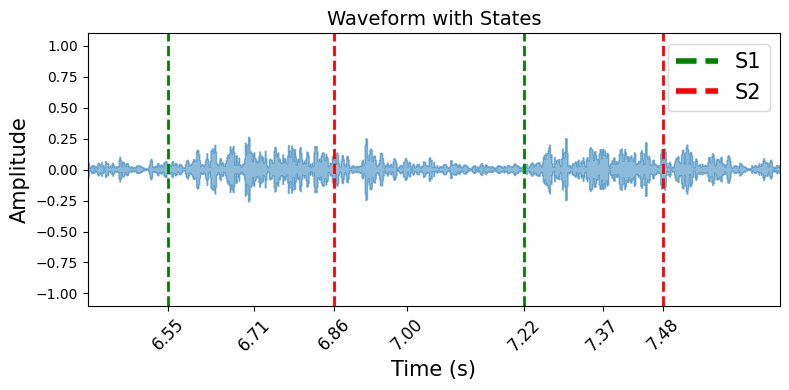

In [42]:
# state 맵핑용 딕셔너리 생성
state_dict = {0: "Noise", 1: 'S1', 2: 'Systole', 3: 'S2', 4: 'Diastole'}

# time-stamp 및 그에 대응되는 x축값 기록용 리스트
time_stamps= []
time_stamps_labels= []

y, sr = librosa.load(train_datapath / f"{filename}.wav", sr=4000)

# 그래프 크기 지정 및 Waveform plot 
plt.figure(figsize=(8, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.5)

for _, row in sample_tsv.iterrows():
    start_time = row['start'] # 시작 지점
    end_time = row['end'] # 종료 지점
    state = row['state'] # 구간 상태
    
    if (start_time > 6.4) & (end_time < 7.7): 
        
        time_stamps.append(start_time)
        time_stamps_labels.append(f"{start_time:.2f}")
        
        # S1 시작점과 종료지점 라인 추가 
        if state == 1:
            plt.axvline(x= start_time, color= 'green', linestyle='--', lw= 2.0, alpha= 1.0)
        # S2 시작점과 종료지점 라인 추가 
        if state == 3:
            plt.axvline(x= start_time, color= 'red', linestyle='--', lw= 2.0, alpha= 1.0)

legend_elements = [
    # Line2D([0], [0], color='black', marker='s', markerfacecolor='black', markersize=10, label='Noise'),
    # Patch(facecolor='gray', edgecolor='black', alpha= 0.7, label='Noise'), 
    Line2D([0], [0], color='green', linestyle='--', lw=4, label='S1'),
    Line2D([0], [0], color='red', linestyle='--', lw=4, label='S2')
]


# 범례 및 축범위 지정
plt.xlim(left= 6.4, right= 7.7)
plt.xticks(time_stamps, labels = time_stamps_labels, fontsize= 12, rotation= 45)


plt.legend(handles=legend_elements, fontsize=15)

# 그래프 제목 및 x, y축 이름
plt.title('Waveform with States', fontsize=14)
plt.xlabel('Time (s)', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)
plt.tight_layout()
plt.show()

In [45]:
config.data_preprocess

{'frequency_high': 800, 'sampling_rate': 4000, 'window_length': 0.05, 'hop_length': 0.02, 'sequence_length': 6, 'clean_noise': True, 'num_k': 5, 'val_fold_num': 3}

In [54]:
sample_rate = config.data_preprocess.sampling_rate

n_fft = int(config.data_preprocess.window_length * sample_rate)
window_length = int(config.data_preprocess.window_length * sample_rate)
hop_length = int(config.data_preprocess.hop_length * sample_rate)

In [57]:
# data_dir = pathlib.Path("/Data2/murmur/train")

sample_rate, recording = read(train_datapath / "9979_AV.wav")
assert sample_rate == 4000

if recording.ndim > 1:  # Handle stereo by converting to mono
    recording = recording.mean(axis=1)

# n_fft = int(0.050 * 4000)         # FFT window size
# hop_length = int(0.020 * 4000)
frequencies, times, Zxx = stft(recording, fs=sample_rate, nperseg=n_fft, noverlap=n_fft - hop_length, 
                               
                            # Added
                            padded= False,
                            return_onesided=True,
                            boundary=None
                            )

magnitude = np.abs(Zxx)
magnitude_db = 20 * np.log10(np.maximum(magnitude, 1e-10))  # Avoid log(0)

In [58]:
recording = torch.tensor(recording).float()
recording -= recording.mean()
recording /= recording.abs().max()

window_length = n_fft
window_step = hop_length

spectrogram = (
    torch.stft(
        recording,
        n_fft=window_length,
        hop_length=window_step,
        window=torch.hann_window(window_length),
        center=False,
        return_complex=False,
    )
    .pow(2)
    .sum(dim=-1)
)

In [59]:
fs_features = int(1 / config.data_preprocess.hop_length)

tsv_path = (train_datapath / "9979_AV.wav").with_suffix(".tsv")
tsv_df = pd.read_csv(tsv_path, sep= "\t", header= None)
tsv_df.columns = ["start", "end", "state"]
tsv_df["start"] = (tsv_df["start"] * fs_features).apply(lambda x: int(x)) 
tsv_df["end"] = (tsv_df["end"] * fs_features).apply(lambda x: int(np.ceil(x)))   

In [60]:
segmentation_label = torch.zeros(3, spectrogram.shape[-1]) 
filename = "9979_AV"

for row in tsv_df.itertuples():
    if row.state == 0: 
        # Noise
        pass
    elif row.state == 1: 
        # S1
        segmentation_label[0 , row.start : row.end] = 1.0
    elif row.state == 2: 
        # Systole
        pass
    elif row.state == 3: 
        # S2
        segmentation_label[1 , row.start : row.end] = 1.0
    else: 
        # Diastole
        pass     
        
    if (row.state == 2) and (recording_df.loc[f"{filename}"]["rec_murmur_label"] == "Present"):
        if recording_df.loc[f"{filename}"]['murmur_timing'] == 'Early-systolic':
                        portion = [0, 0.5]
        elif recording_df.loc[f"{filename}"]['murmur_timing'] == 'Holosystolic':
            portion = [0, 1]
        elif recording_df.loc[f"{filename}"]['murmur_timing'] == 'Mid-systolic':
            portion = [0.25, 0.75]
        elif recording_df.loc[f"{filename}"]['murmur_timing'] == 'Late-systolic':
            portion = [0.5, 1]
        else:
            portion = [0, 0]

        state_duration = row.end - row.start 
        start = int(row.start + portion[0] * state_duration)
        end = int(np.ceil(row.start + portion[1] * state_duration))
        segmentation_label[-1,  start : end] = 1.0

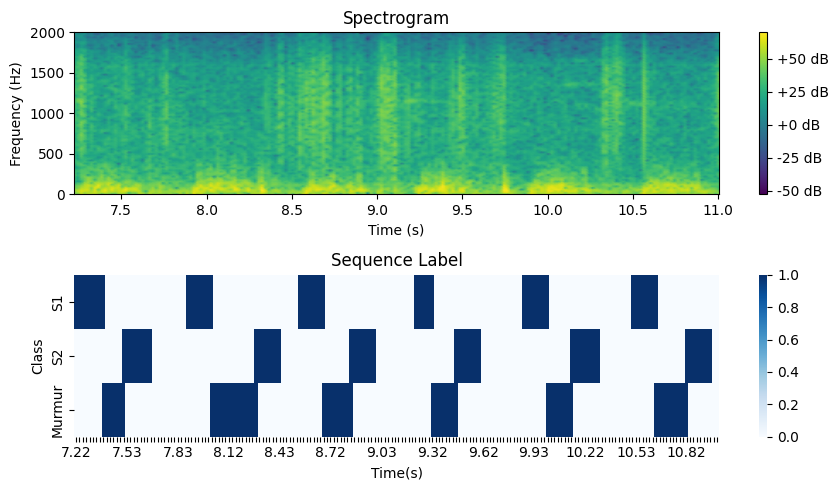

In [61]:
fig, axes = plt.subplots(2, 1, figsize=(9, 5))  # 2행 1열, 플롯 크기 설정

class_list = ["S1", "S2", "Murmur"]
plot_x = [f"{time:.2f}" if idx % 15 == 0 else "" # 15개 단위로만 time-stamp 스택
          for idx, time in enumerate(times) ] # 


# 스펙트로그램 plot
im1 = axes[0].pcolormesh(times[360:550], frequencies, magnitude_db[:, 360:550], shading='gouraud', cmap='viridis')  # 360:550 부분만 plot
# axes[0].colorbar(format='%+2.0f dB')
fig.colorbar(im1, ax=axes[0], format='%+2.0f dB')  # 첫 번째 플롯에 색상 바 추가
axes[0].set_title("Spectrogram")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Frequency (Hz)")
axes[0].set_ylim(0, 2000) 


C, T = segmentation_label.shape

sns.heatmap(segmentation_label[:, 360:550], cmap="Blues", cbar=True, xticklabels= plot_x[360:550], yticklabels=[f'{class_list[i]}' for i in range(C)], 
            ax= axes[1])
axes[1].tick_params(axis='x', labelrotation=0)  # x축 레이블을 45도 회전
axes[1].set_title("Sequence Label")
axes[1].set_xlabel("Time(s)")
axes[1].set_ylabel("Class")
plt.tight_layout()
plt.show()